# 로보플로우에서 바운딩 좌표와 이미지를 불러옵니다.

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="JWTDSryWS30F0shsNi3x")
project = rf.workspace("object-detection-project1").project("-jnhcg")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


# 객체 검출 모델 학습때와 동일하게 바운딩 좌표의 클래스를 분류해줍니다.
- Jupyter notebook 환경이기때문에 일부 코드를 수정했습니다.

In [2]:
import os

def update_second_line_in_folders(folder_paths):
    for folder_path in folder_paths:
        print(f"폴더: {folder_path}")
        # 폴더 내의 모든 텍스트 파일에 대해 작업
        for filename in os.listdir(folder_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(folder_path, filename)

                # 텍스트 파일 읽기
                with open(file_path, 'r') as file:
                    lines = file.readlines()

                # 두 번째 줄이 존재하고, 맨 앞의 숫자가 0일 경우에만 작업 수행
                if len(lines) > 1 and lines[1][0] == '0':
                    # 두 번째 줄의 맨 앞의 0을 1로 변경
                    lines[1] = '1' + lines[1][1:]

                    # 변경된 텍스트 파일 저장 (기존 파일 덮어쓰기)
                    with open(file_path, 'w') as file:
                        file.writelines(lines)

                    # 확인을 위해 변경된 부분 출력
                    print(f"{filename} - 변경 후 두 번째 줄: {lines[1].strip()}")

        print("작업 완료\n")

# 사용자에게 폴더 경로 입력 받기
dataset_folder1 = '/Users/dessert_gomjelly/Desktop/yolo project/색상검출/패션-2/test/labels' 
dataset_folder2 = '/Users/dessert_gomjelly/Desktop/yolo project/색상검출/패션-2/train/labels'
dataset_folder3 = '/Users/dessert_gomjelly/Desktop/yolo project/색상검출/패션-2/valid/labels'

# 함수 호출
update_second_line_in_folders([dataset_folder1, dataset_folder2, dataset_folder3])


폴더: /Users/dessert_gomjelly/Desktop/yolo project/색상검출/패션-2/test/labels
작업 완료

폴더: /Users/dessert_gomjelly/Desktop/yolo project/색상검출/패션-2/train/labels
작업 완료

폴더: /Users/dessert_gomjelly/Desktop/yolo project/색상검출/패션-2/valid/labels
작업 완료



<br>
<Br>
 
#### 평균 색상을 통한 추출 방식과 히스토그램으로 색상을 추출 방식은 실패했습니다.

## 따라서 KMeans 클러스터링으로 주요 색상 추출을 실행합니다.
-  각 픽셀의 RGB 값을 하나의 데이터 포인트로 간주하고, 모든 픽셀을 1차원 배열로 변환 후 K-Means 클러스터링 수행

In [3]:
from PIL import Image, ImageDraw
from sklearn.cluster import KMeans
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

In [4]:
# 바운딩 박스 좌표를 정규화된 좌표에서 실제 좌표로 변환하는 함수

def convert_normalized_coordinates(bbox, image_width, image_height):
    class_label, x_center, y_center, width, height = bbox

    x = int((x_center - width/2) * image_width)
    y = int((y_center - height/2) * image_height)
    w = int(width * image_width)
    h = int(height * image_height)

    return class_label, x, y, w, h

In [5]:
# 이미지에서 주요 색상을 추출하는 함수

def extract_major_colors(image_path, bounding_boxes):

    all_major_colors = []
    image = None  # 이미지 변수 초기화

    try:
        image = Image.open(image_path)

        for bbox in bounding_boxes:
            class_label, x, y, w, h = convert_normalized_coordinates(bbox, image.width, image.height)

            # 바운딩 박스 그리기
            draw = ImageDraw.Draw(image)
            draw.rectangle([x, y, x + w, y + h], outline="green", width=2)

            # 주요 색상 추출 (kmeans_find_major_color 함수 사용)
            major_color = kmeans_find_major_color(image.crop((x, y, x + w, y + h)))

            # 주요 색상과 클래스 레이블 저장
            if major_color is not None:
                all_major_colors.append((class_label, major_color))
                
    except Exception as e:
        print(f"에러 발생: {e} - 이미지 파일: {image_path}")

    return all_major_colors, image  # 이미지 변수 반환


In [6]:
# 이미지에서 K-Means 클러스터링을 사용하여 주요 색상 추출하는 함수

def kmeans_find_major_color(image):

    pixels = np.array(image).reshape((-1, 3))
    kmeans = KMeans(n_clusters=1, n_init=10, random_state=42)
    kmeans.fit(pixels)

    if kmeans.cluster_centers_ is not None and len(kmeans.cluster_centers_) > 0:
        dominant_color = tuple(map(int, kmeans.cluster_centers_[0]))
        return dominant_color
    else:
        return None



In [7]:
# 주요 색상 데이터를 CSV 파일로 저장하는 함수

def save_to_csv(data, filename):
    
    try:
        with open(filename, 'a', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            for row in data:
                if row[1] is not None:  # 주요 색상이 None이 아닌 경우에만 추가
                    csv_writer.writerow(row)
    except Exception as e:
        print(f"에러 발생: {e} - CSV 파일 저장 중 문제 발생")

색상추출 결과 [(0.0, (210, 86, 16)), (1.0, (141, 130, 109))]


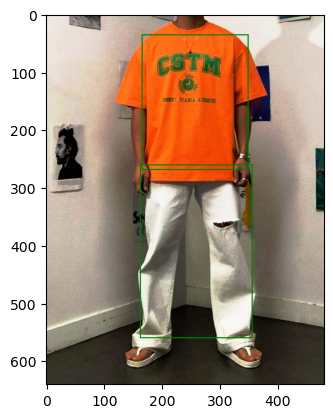

In [8]:
# 이미지와 바운딩 박스 디렉토리 설정
image_dir = "패션-2/test/images"
bbox_dir = "패션-2/test/labels"

# 실험 파일 설정
image_file = "T_17873_19_normcore_M_jpg.rf.6aa18d4052dfd9743089a04b933eed9e.jpg"
bbox_file = "T_17873_19_normcore_M_jpg.rf.6aa18d4052dfd9743089a04b933eed9e.txt"

# 이미지와 바운딩 박스 경로 설정
image_path = os.path.join(image_dir, image_file)
bbox_path = os.path.join(bbox_dir, bbox_file)

try:
    # 바운딩 박스 데이터 읽기
    with open(bbox_path, "r") as file:
        bounding_boxes = [list(map(float, line.split())) for line in file]

    # 주요 색상 추출 및 저장
    all_major_colors, image = extract_major_colors(image_path, bounding_boxes)

except Exception as e:
    print(f"에러 발생: {e} - 바운딩 박스 파일: {bbox_path}")

# 결과를 CSV 파일로 저장
save_to_csv(all_major_colors, 'output99.csv')

# 주요 색상이 그려진 이미지를 화면에 표시
print('색상추출 결과', all_major_colors)
plt.imshow(image)
plt.show()

## [색상 코드 변환기](https://www.rapidtables.org/ko/convert/color/index.html) 링크를 들어가서 RGB 코드를 입력하면 해당 색상이 나타남을 알 수 있습니다.
- #### 예를 들어 RED : 210, BLUE: 86, GREEN: 16 을 입력하면 주황색 이 나타남을 확인 할 수 있습니다.

# 다른 이미지에 대해서도 테스트

색상추출 결과 [(0.0, (167, 160, 138)), (1.0, (85, 93, 97))]


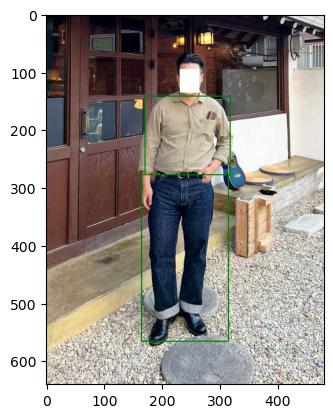

In [9]:
# 이미지와 바운딩 박스 디렉토리 설정
image_dir = "패션-2/train/images"
bbox_dir = "패션-2/train/labels"

# 다른 이미지와 레이블 파일 선택
new_image_file = "T_17294_19_normcore_M_jpg.rf.66c37f838e853001a017efcb99654556.jpg"
new_bbox_file = "T_17294_19_normcore_M_jpg.rf.66c37f838e853001a017efcb99654556.txt"

# 이미지와 바운딩 박스 경로 설정
new_image_path = os.path.join(image_dir, new_image_file)
new_bbox_path = os.path.join(bbox_dir, new_bbox_file)

try:
    # 바운딩 박스 데이터 읽기
    with open(new_bbox_path, "r") as file:
        new_bounding_boxes = [list(map(float, line.split())) for line in file]

    # 주요 색상 추출 및 저장
    new_all_major_colors, new_image = extract_major_colors(new_image_path, new_bounding_boxes)

except Exception as e:
    print(f"에러 발생: {e} - 바운딩 박스 파일: {new_bbox_path}")

# 결과를 CSV 파일로 저장
save_to_csv(new_all_major_colors, 'new_output.csv')

# 주요 색상이 그려진 이미지를 화면에 표시
print('색상추출 결과', new_all_major_colors)
plt.imshow(new_image)
plt.show()


<br>

# 이제 전체 파일에 대해서 실행한다.

In [11]:
def process_images(image_dir, bbox_dir, output_csv):
    all_major_colors = []  # 모든 이미지에 대한 주요 색상을 저장할 리스트 초기화

    try:
        # 이미지 디렉토리에 있는 모든 파일에 대해 반복
        for file_name in os.listdir(image_dir):
            # 이미지 파일 경로
            image_path = os.path.join(image_dir, file_name)

            # 해당 이미지 파일에 대응하는 바운딩 박스 파일 경로
            bbox_file_name = os.path.splitext(file_name)[0] + ".txt"
            bbox_path = os.path.join(bbox_dir, bbox_file_name)

            try:
                # 바운딩 박스 데이터 읽기
                with open(bbox_path, "r") as file:
                    bounding_boxes = [list(map(float, line.split())) for line in file]

                # 주요 색상 추출 및 저장
                current_major_colors, _ = extract_major_colors(image_path, bounding_boxes)

                # 현재 이미지의 주요 색상을 전체 리스트에 추가
                all_major_colors.extend(current_major_colors)

            except Exception as e:
                print(f"에러 발생: {e} - 바운딩 박스 파일: {bbox_path}")

    except Exception as e:
        print(f"에러 발생: {e} - 이미지 디렉토리: {image_dir}")

    # 결과를 CSV 파일로 저장
    save_to_csv(all_major_colors, output_csv)

# 색상검출
process_images("패션-2/train/images", "패션-2/train/labels", 'train색상검출완료.csv')
process_images("패션-2/test/images", "패션-2/test/labels", 'test색상검출완료.csv')
process_images("패션-2/valid/images", "패션-2/valid/labels", 'valid색상검출완료.csv')
